### In-Patient: Indication of Readmitting to the hospital

Problem Statement: Given patient history,admission and diagnosis details, analyze and predict the patient getting readmitted to the hospital with in 1 month of the diagnosis

**Hypothesis:**
- Patients with higher risk rate have more chance of getting readmitted to the hospital.
- Elderly patients have more chance of getting readmitted.
- Patients admitted electively have less chance of coming back to hospital.
- Patients with higher fitness rate have less chance of readmission.
- Patients who have habit of missing on-time medication have high chance of readmission.

In [1]:
import os, pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, warnings

from modeldb.sklearn_native.ModelDbSyncer import *
from modeldb.sklearn_native import SyncableMetrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from sklearn2pmml.pipeline import PMMLPipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

#from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import accuracy_score
#from sklearn.grid_search import GridSearchCV

%matplotlib inline
sns.set()
warnings.filterwarnings("ignore") # suppress all warnings 

/home/ubuntu/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ubuntu/.local/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
df = pd.read_csv("Patient_Data.csv")
print("Number of rows:", df.shape[0],"\nNumber of columns:",df.shape[1])

Number of rows: 12491 
Number of columns: 23


**Sample Data**

In [3]:
df.head()

,gender,age,Age_Range,patient_age_group,Patient Type,marital_status,appointment_date,appointment_time,neighbourhood,distance,...,sms_received,Primary Condition,Last Appointment_show_no_show,Current Condition,Type of Admission,Patient Disposition,Medication On Time,Fitness rate,Risk,Readmission
0,F,73,61 to 85,elderly,Inpatient,Single,NaN,10:54,Whitner,3,...,Y,Thyroid,Y,Elbow Fracture,Elective,Court/Law Enforcement,Y,2,10,N
1,M,68,61 to 85,elderly,Inpatient,Divorced,NaN,16:14,Hopewell,5,...,Y,Arthritis,N,NaN,Emergency,Skilled Nursing Home,Y,3,5,N
2,F,83,61 to 85,elderly,Inpatient,Married,NaN,14:36,Wyandotte,7,...,Y,Cataracts,N,Head Injury,Emergency,InpatientRehabilitation Facility,N,3,19,Y
3,M,62,61 to 85,elderly,Inpatient,Single,NaN,14:22,Greenwood,12,...,Y,Chronic Kidney Disease,Y,NaN,Elective,Cancer Center,Y,2,2,N
4,F,39,31 to 40,adult,Inpatient,Unknown,NaN,11:44,Hawthorne,16,...,Y,Knee Replacement,N,NaN,Elective,Expired,N,2,18,N


# EDA

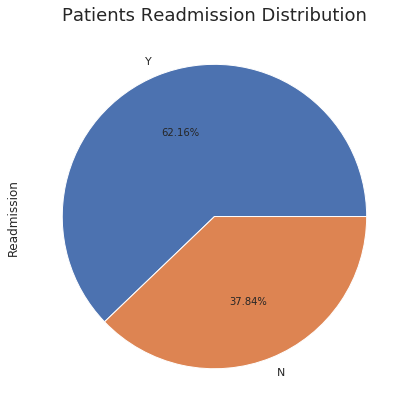

In [4]:
plt.figure(figsize=(10,5))
ax = df['Readmission'].value_counts().plot(kind='pie', figsize=(10,7),autopct = "%1.2f%%")
ax.set_title("Patients Readmission Distribution", fontsize=18)
plt.show()

62% of patients have turned out to get readmitted because of various reasons.

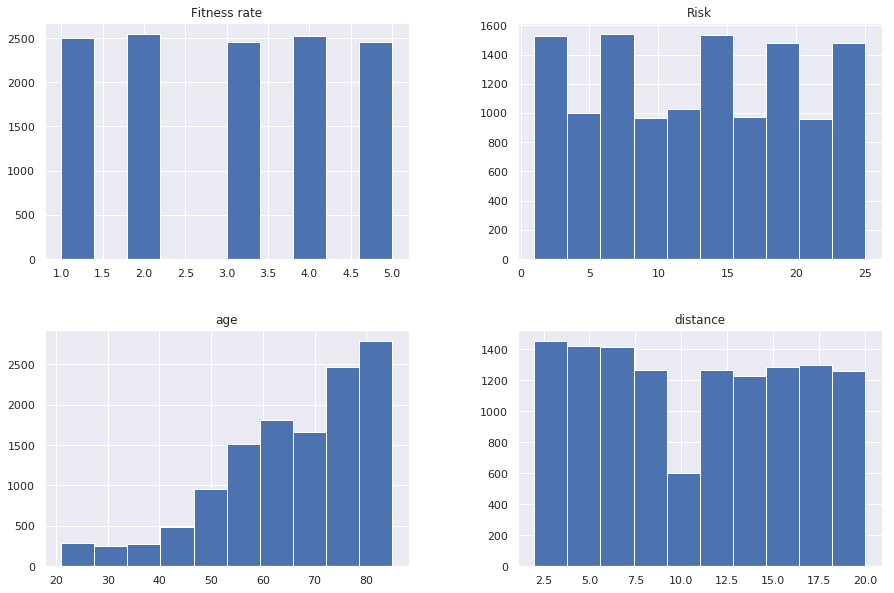

In [5]:
fig = plt.figure(figsize = (15,10))
ax = fig.gca()
df.hist(ax=ax)
plt.show()

Patient Data Distributions

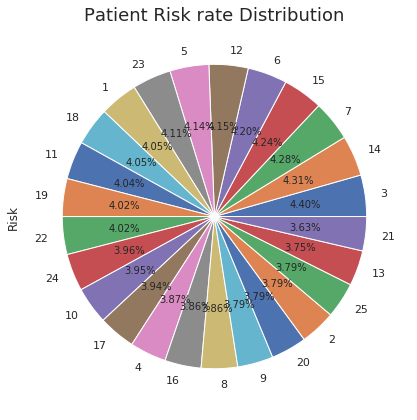

In [6]:
plt.figure(figsize=(10,5))
ax = df['Risk'].value_counts().plot(kind='pie', figsize=(10,7),autopct = "%1.2f%%")
ax.set_title("Patient Risk rate Distribution", fontsize=18)
plt.show()

More or less similar % of patients are found in each risk rate category.

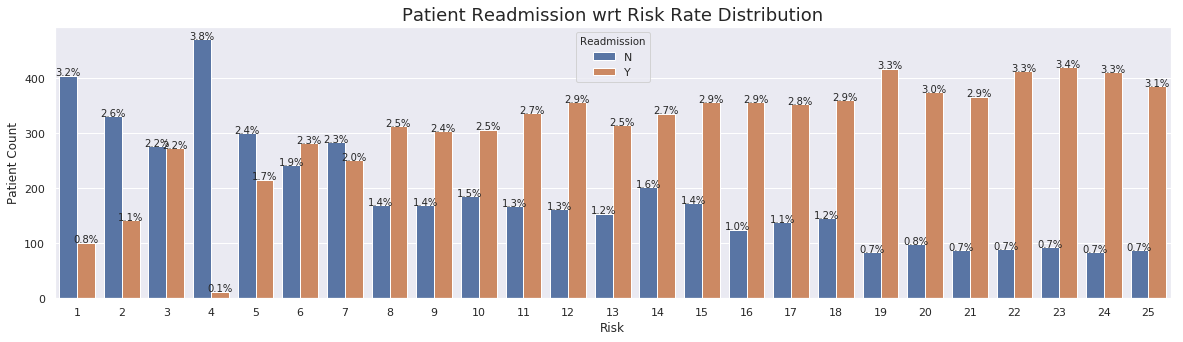

In [7]:
f, ax = plt.subplots(1,1,figsize=(20,5))
sns.countplot(x = 'Risk', hue = 'Readmission', data = df,ax=ax,capsize=0.1)
ax.set_title("Patient Readmission wrt Risk Rate Distribution",fontsize = 18)
ax.set_ylabel('Patient Count')

# find the values and append to list
totals = []
for i in ax.patches:
    totals.append(i.get_bbox().get_points()[1,1])
total = sum(totals)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*(y/total)), (x.mean(), y), ha='center') # set the alignment of the text

Patients with higher risk rates have higher percentage of readmission.

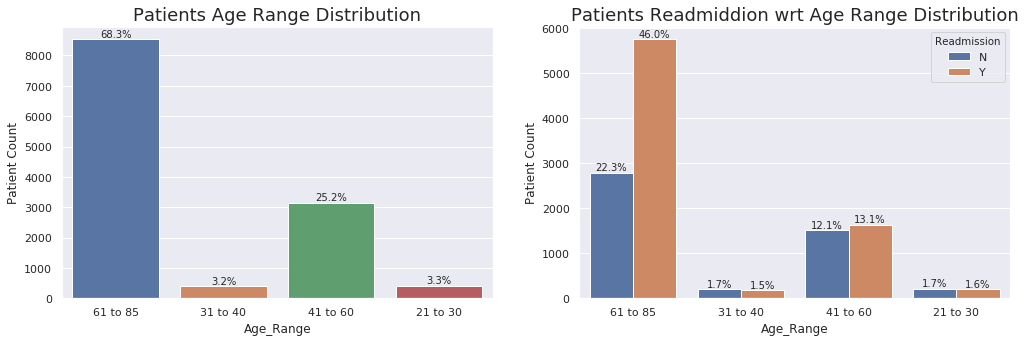

In [8]:
f, ax = plt.subplots(1,2,figsize=(17,5))
sns.countplot(x = 'Age_Range', hue = 'Readmission', data = df,ax=ax[1],capsize=0.1)
ax[1].set_title("Patients Readmiddion wrt Age Range Distribution",fontsize = 18)
ax[1].set_ylabel('Patient Count')

# find the values and append to list
totals = []
for i in ax[1].patches:
    totals.append(i.get_bbox().get_points()[1,1])
total = sum(totals)

for p in ax[1].patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax[1].annotate('{:.1f}%'.format(100.*(y/total)) , (x.mean(), y), ha='center', va='bottom') # set the alignment of the text

sns.countplot(x = 'Age_Range', data = df,ax=ax[0],capsize=0.1)
ax[0].set_title("Patients Age Range Distribution",fontsize = 18)
ax[0].set_ylabel('Patient Count')

# find the values and append to list
totals = []
for i in ax[0].patches:
    totals.append(i.get_bbox().get_points()[1,1])
total = sum(totals)

for p in ax[0].patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax[0].annotate('{:.1f}%'.format(100.*(y/total)) , (x.mean(), y), ha='center', va='bottom') # set the alignment of the text

plt.show()

Elderly patients have more chance of getting readmitted to hospital. 

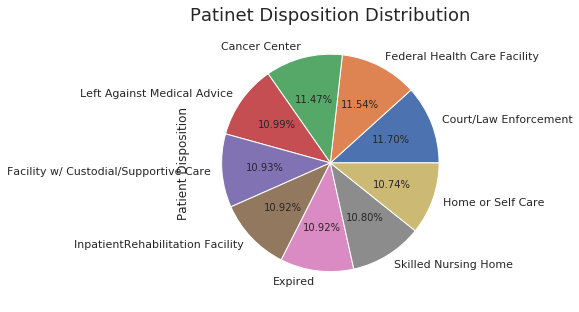

In [9]:
f, ax = plt.subplots(1,1,figsize=(18,5))
ax = df['Patient Disposition'].value_counts().plot(kind='pie', autopct = "%1.2f%%")
ax.set_title("Patinet Disposition Distribution", fontsize=18)
plt.show()

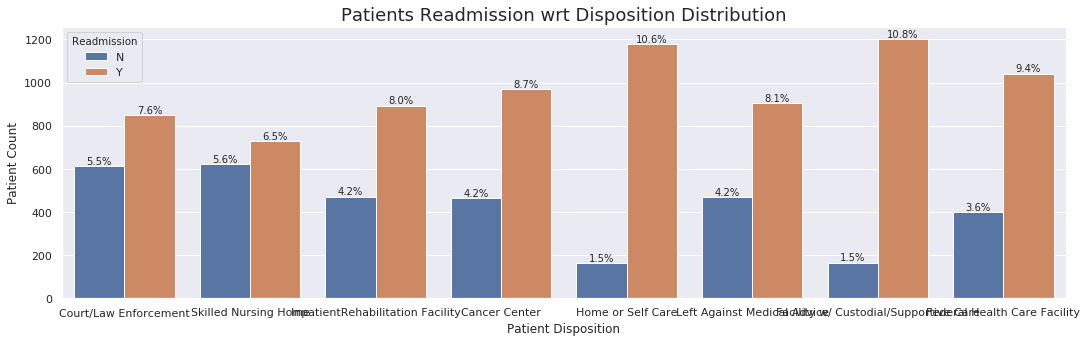

In [10]:
testDF = df[['Patient Disposition','Readmission']]
testDF = df.loc[df['Patient Disposition'] != 'Expired']
f, ax = plt.subplots(1,1,figsize=(18,5))
sns.countplot(x = 'Patient Disposition', hue = 'Readmission', data = testDF,ax=ax)
ax.set_title("Patients Readmission wrt Disposition Distribution",fontsize = 18)
ax.set_ylabel('Patient Count')

# find the values and append to list
totals = []
for i in ax.patches:
    totals.append(i.get_bbox().get_points()[1,1])
total = sum(totals)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*(y/total)) , (x.mean(), y), ha='center', va='bottom') # set the alignment of the text


Self care patients have more chance of getting readmitted to hospital.

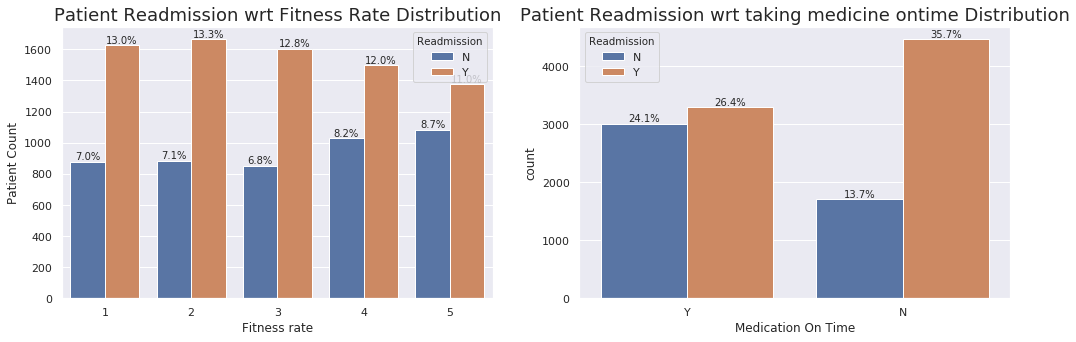

In [11]:
f, ax = plt.subplots(1,2,figsize=(17,5))
sns.countplot(x = 'Fitness rate', hue = 'Readmission', data = df,ax=ax[0],capsize=0.1)
ax[0].set_title("Patient Readmission wrt Fitness Rate Distribution",fontsize = 18)
ax[0].set_ylabel('Patient Count')

# find the values and append to list
totals = []
for i in ax[0].patches:
    totals.append(i.get_bbox().get_points()[1,1])
total = sum(totals)

for p in ax[0].patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax[0].annotate('{:.1f}%'.format(100.*(y/total)) , (x.mean(), y), ha='center', va='bottom') # set the alignment of the text

sns.countplot(x = 'Medication On Time', hue = 'Readmission', data = df,ax=ax[1],capsize=0.1)
ax[1].set_title("Patient Readmission wrt taking medicine ontime Distribution" ,fontsize = 18)
ax[0].set_ylabel('Patient Count')

# find the values and append to list
totals = []
for i in ax[1].patches:
    totals.append(i.get_bbox().get_points()[1,1])
total = sum(totals)

for p in ax[1].patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax[1].annotate('{:.1f}%'.format(100.*(y/total)), (x.mean(), y), ha='center', va='bottom') # set the alignment of the text

plt.show()

Higher fitness rated patients have less chance of readmission.
AND
Patients who take medicines on time also have less chance of readmission.

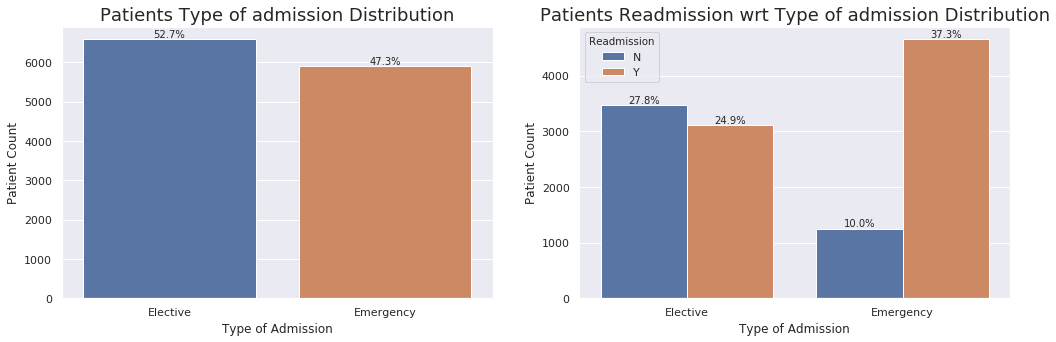

In [12]:
f, ax = plt.subplots(1,2,figsize=(17,5))
sns.countplot(x = 'Type of Admission', hue = 'Readmission', data = df,ax=ax[1],capsize=0.1)
ax[1].set_title("Patients Readmission wrt Type of admission Distribution",fontsize = 18)
ax[1].set_ylabel('Patient Count')

# find the values and append to list
totals = []
for i in ax[1].patches:
    totals.append(i.get_bbox().get_points()[1,1])
total = sum(totals)

for p in ax[1].patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax[1].annotate('{:.1f}%'.format(100.*(y/total)) , (x.mean(), y), ha='center', va='bottom') # set the alignment of the text

sns.countplot(x = 'Type of Admission', data = df,ax=ax[0],capsize=0.1)
ax[0].set_title("Patients Type of admission Distribution",fontsize = 18)
ax[0].set_ylabel('Patient Count')

# find the values and append to list
totals = []
for i in ax[0].patches:
    totals.append(i.get_bbox().get_points()[1,1])
total = sum(totals)

for p in ax[0].patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax[0].annotate('{:.1f}%'.format(100.*(y/total)) , (x.mean(), y), ha='center', va='bottom') # set the alignment of the text

plt.show()

Patients who got admitted through emergency have high chance of getting readmitted to the hospital.

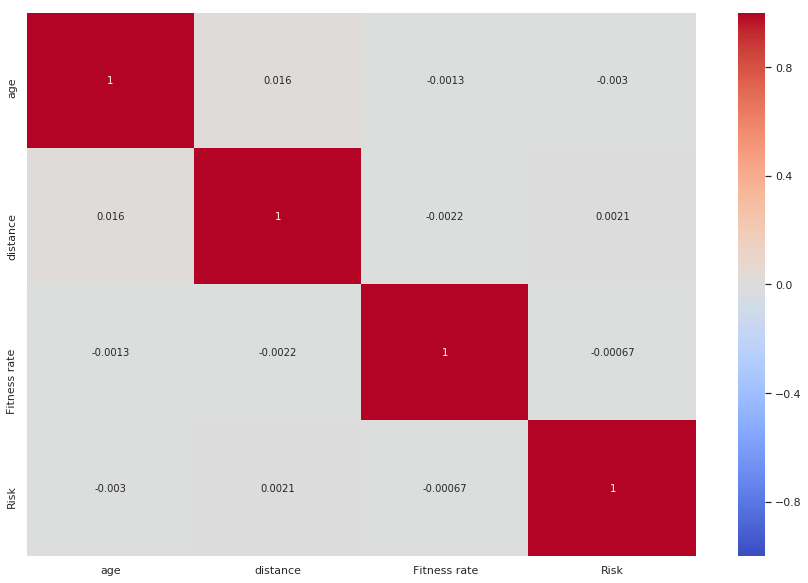

In [13]:
# generating correlation heatmap 
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), vmin=-1,cmap='coolwarm', annot=True);

In [16]:
X = df[['gender', 'age','patient_age_group', 'marital_status','alcholism', 'handicap', 'Type of Admission', 'Patient Disposition', 'Medication On Time',
       'Fitness rate', 'Risk']]
y = df[['Readmission']]

In [17]:
#Label Encoding 
le = LabelEncoder()
#y['noshow'] = le.fit_transform(y['noshow'])
X['gender'] = le.fit_transform(X['gender'])
X['marital_status'] = le.fit_transform(X['marital_status'])
X['patient_age_group'] = le.fit_transform(X['patient_age_group'])
X['alcholism'] = le.fit_transform(X['alcholism'])
X['handicap'] = le.fit_transform(X['handicap'])
X['Type of Admission'] = le.fit_transform(X['Type of Admission'])
X['Patient Disposition'] = le.fit_transform(X['Patient Disposition'])
X['Medication On Time'] = le.fit_transform(X['Medication On Time'])
X['Fitness rate'] = le.fit_transform(X['Fitness rate'])
X['Risk'] = le.fit_transform(X['Risk'])

In [18]:
# Creating a new project

name = "Patients Readmission Classification"
author = "Manmohan Sharma"
description = "Classification Technique"
syncer_obj = Syncer(
    NewOrExistingProject(name, author, description),
    NewOrExistingExperiment("Patients Readmission Classification", "Patients Readmission Classification"),
    NewExperimentRun("Patients Readmission Classification"))

In [19]:
all_inputs = X
all_classes = df['Readmission']

In [20]:
syncer_obj.add_tag(all_inputs, "data to input into model")

In [21]:
# Make sure that you don't mix up the order of the entries
# all_inputs[5] inputs should correspond to the class in all_classes[5]

(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = cross_validation.train_test_split_sync(
    all_inputs, all_classes, train_size=0.80, random_state=1)

In [22]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [23]:
classifier_RF =RandomForestClassifier()
syncer_obj.add_tag(classifier_RF, "random forest")
classifier_RF.fit_sync(training_inputs, training_classes)
# Validate the classifier on the testing set using classification accuracy
# decision_tree_classifier.score(testing_inputs, testing_classes)

# NOTE: score is equivalent to sklearn.metrics.accuracy_score.
SyncableMetrics.compute_metrics(
    classifier_RF, accuracy_score, testing_classes,
    classifier_RF.predict(testing_inputs), training_inputs, "", "")

# cross_val_score returns a list of the scores, which we can visualize
# to get a reasonable estimate of our classifier's performance
cv_scores = cross_validation.cross_val_score_sync(classifier_RF, all_inputs, all_classes, cv=5)

syncer_obj.sync()

In [24]:
cv_scores

array([0.95558223, 0.96238495, 0.95596477, 0.96277022, 0.96595915])

In [25]:
classifier_LR =LogisticRegression()
syncer_obj.add_tag(classifier_LR, "logistic regression")
classifier_LR.fit_sync(training_inputs, training_classes)
# Validate the classifier on the testing set using classification accuracy
# decision_tree_classifier.score(testing_inputs, testing_classes)

# NOTE: score is equivalent to sklearn.metrics.accuracy_score.
SyncableMetrics.compute_metrics(
    classifier_LR, accuracy_score, testing_classes,
    classifier_LR.predict(testing_inputs), training_inputs, "", "")

# cross_val_score returns a list of the scores, which we can visualize
# to get a reasonable estimate of our classifier's performance
cv_scores = cross_validation.cross_val_score_sync(classifier_LR, all_inputs, all_classes, cv=5)

syncer_obj.sync()

In [26]:
classifier_DT = DecisionTreeClassifier()
syncer_obj.add_tag(classifier_DT, "Decision Tree")
classifier_DT.fit_sync(training_inputs, training_classes)
# Validate the classifier on the testing set using classification accuracy
# decision_tree_classifier.score(testing_inputs, testing_classes)

# NOTE: score is equivalent to sklearn.metrics.accuracy_score.
SyncableMetrics.compute_metrics(
    classifier_DT, accuracy_score, testing_classes,
    classifier_DT.predict(testing_inputs), training_inputs, "", "")

# cross_val_score returns a list of the scores, which we can visualize
# to get a reasonable estimate of our classifier's performance
cv_scores = cross_validation.cross_val_score_sync(classifier_DT, all_inputs, all_classes, cv=5)

syncer_obj.sync()

In [27]:
pipeline = PMMLPipeline([("classifier", classifier_RF)])

#pipeline.fit(X_train,y_train['Readmission'])
pipeline.fit(all_inputs,all_classes)

#pickle pipeline
pipeline_pickle_file = "/home/ubuntu/data-science-workbench/model-deployer/deploy/patient_readmit.pkl.z"
joblib.dump(pipeline, pipeline_pickle_file, compress = 9)

['/home/ubuntu/data-science-workbench/model-deployer/deploy/patient_readmit.pkl.z']